In [1]:
versioninfo()

Julia Version 1.10.4
Commit 48d4fd4843 (2024-06-04 10:41 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 24 × 12th Gen Intel(R) Core(TM) i9-12900K
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, alderlake)
Threads: 12 default, 0 interactive, 6 GC (on 24 virtual cores)
Environment:
  JULIA_NUM_THREADS = 12


In [2]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.status()

  Activating project at `C:\Users\o6m1g\Documents\GitHub\ASMC-BayesCV`


Status `C:\Users\o6m1g\Documents\GitHub\ASMC-BayesCV\Project.toml`
  [0bf59076] AdvancedHMC v0.8.0
  [336ed68f] CSV v0.10.15
  [a93c6f00] DataFrames v1.7.0
  [31c24e10] Distributions v0.25.120
  [4138dd39] JLD v0.13.5
  [b964fa9f] LaTeXStrings v1.4.0
  [6fdf6af0] LogDensityProblems v2.1.2
  [86f7a689] NamedArrays v0.10.4
  [ce719bf2] PSIS v0.9.8
  [91a5bcdd] Plots v1.40.17
  [92933f4c] ProgressMeter v1.10.4
  [f2b01f46] Roots v2.2.8
  [2913bbd2] StatsBase v0.34.5
  [4c63d2b9] StatsFuns v1.5.0
  [f3b207a7] StatsPlots v0.15.7
⌅ [fce5fe82] Turing v0.39.6
  [ade2ca70] Dates
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


# Setup

In [3]:
include("Init.jl")

In [4]:
println("Running on ", Threads.nthreads(), " threads.")

Running on 12 threads.


In [5]:
RUN_MCMC = false
RUN_aSMC = true;

In [6]:
# Tag by timestamp
SESSION = Dates.format(now(), "yyyy-mm-dd-HH-MM-SS");

# Data

In [7]:
# Load data
df = CSV.read(joinpath("data", "yield.csv"), DataFrame);

# Define data structure for the Dynamic Nelson-Siegel (DNS) model
mutable struct Data_DNS
    y::Matrix{Float64}    # (T,K) matrix of yields (Time steps × maturities)
    T::Int64
    K::Int64
    τ_axis::Vector{Int64} # Vector of maturities in months
    X::Matrix{Float64}    # (K,3) matrix [1 S(τ) S(τ)-exp] of factor loadings
    dates::Vector         # Corresponding dates for each row
    ρ::Float64            # Likelihood power coef on y_T (for Gibbs sampler)
end

function generate_data(T::Int=size(df,1))
    _df = df[1:T,2:end] # exclude first col (date)

    # Parse column names to extract τ
    τ_axis = [parse(Int64, τ_string) for τ_string in names(df[:,2:end])]
    τ_axis = 12τ_axis # in months from years

    x(τ) = (λ_t = 0.0609;
        _m = τ * λ_t;
        _exp = exp(-_m);
        _s = (1 - _exp) / _m;
        [1, _s, _s - _exp]
    )
    
    global data = Data_DNS(
        _df |> Matrix,
        size(_df, 1),
        size(_df, 2),
        τ_axis,
        vecvec2mat(x.(τ_axis)),
        df.index,
        1.
    )
end

generate_data (generic function with 2 methods)

In [8]:
generate_data()

Data_DNS([0.293 0.905 … 2.49 2.643; 0.286 0.944 … 2.537 2.666; … ; 0.048 0.233 … 1.404 1.662; 0.094 0.312 … 1.516 1.79], 293, 5, [24, 60, 120, 240, 360], [1.0 0.52554392871227 0.2936789349181237; 1.0 0.2665880208221924 0.24070064890648354; … ; 1.0 0.0684181411392243 0.06841769203012686; 1.0 0.0456121145639038 0.04561211426293063], [Date("1999-09-01"), Date("1999-10-01"), Date("1999-11-01"), Date("1999-12-01"), Date("2000-01-01"), Date("2000-02-01"), Date("2000-03-01"), Date("2000-04-01"), Date("2000-05-01"), Date("2000-06-01")  …  Date("2023-04-01"), Date("2023-05-01"), Date("2023-06-01"), Date("2023-07-01"), Date("2023-08-01"), Date("2023-09-01"), Date("2023-10-01"), Date("2023-11-01"), Date("2023-12-01"), Date("2024-01-01")], 1.0)

In [9]:
include("LEO.jl")

# MCMC

## Initial draw

In [9]:
Random.seed!(1)
if RUN_MCMC
    Θ = Params(); chain = Params[]
    @showprogress for r in 1:12_000
        Θ |> GibbsScan
        if (r > 2_000) & (r % 10 == 0)
            push!(chain, Θ |> deepcopy)
        end
    end
    _dir = joinpath("output_$(SESSION)", "DNS", "mcmc")
    isdir(_dir) || mkpath(_dir) # Ensure path is present
    save(joinpath(_dir, "chain.jld"), "data", chain)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:40


# LEO

In [10]:
leave_ends = size(df, 1):-1:size(df, 1)-20 # namely [293, 292, ..., 273]

293:-1:273

## Naive

In [31]:
Random.seed!(1)

if RUN_MCMC
    times = Float64[]
    
    @showprogress for T in leave_ends
        """Create data"""
        # exclude last;
        # y_t (t=1,...,T-1) for posterior inference,
        # y_T for validation
        generate_data(T-1)
        
        """MCMC"""
        Θ = Params(); chain = Params[]
        time = @elapsed for r in 1:12_000
            Θ |> GibbsScan
            if (r > 2_000) & (r % 10 == 0)
                push!(chain, Θ |> deepcopy)
            end
        end
        push!(times, time)
        
        _dir = joinpath("output_$(SESSION)", "DNS", "mcmc")
        isdir(_dir) || mkpath(_dir) # Ensure path is present
        save(joinpath(_dir, "chain_leo-$(T).jld"), "data", chain)
        save(joinpath(_dir, "times_naive-leo.jld"), "data", times)
        # break
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 1:20:01


## aSMC

In [11]:
function run_SMC(chain::Vector{Params}; save_bool::Bool=false)

    # Refresh T
    generate_data()
    
    # Define problem dimensions
    R = length(chain)
    L = 5
    H = length(leave_ends)

    # Obtain prior draw
    Θ_0 = chain
    
    # Initialize containers
    particles = NamedArray(repeat([Θ_0], H, L+1), (leave_ends, 0:L), (:T, :l)) # some may not be updated
    ϕ_history = NamedArray(zeros(H, L+1),         (leave_ends, 0:L), (:T, :l))
    L_history = NamedArray(repeat([-1], H),       leave_ends,        :T      )
    times     = NamedArray(zeros(H),              leave_ends,        :T      )
    
    # Log weights normalizer
    function _normalize(_log_w::Vector{Float64})::Vector{Float64}
        _w = exp.(_log_w .- maximum(_log_w))
        _w = _w / sum(_w)
        _w
    end

    # Effective sample size
    function _ess(_w::Vector{Float64})::Float64
        1 / sum(@. exp(2 * log(_w)))
    end
    
    # Log ratio
    function log_G(T::Int, l::Int, n::Int)::Float64
        _particle = particles[:T => T, :l => l-1][n]
        -logpdf(MvNormal(data.X * _particle.β[T,:], _particle.Σ_y), data.y[T,:])
    end

    for (T_i, T) in enumerate(leave_ends); @info T
        
        # Set initial values for T_i-th iteration, case-deleting y_T.
        # If very first, begin with baseline MCMC
        # Otherwise, inherit the previous (T_i - 1)-th iteration
        # particles: in particular its latest one.
        if T_i == 1
            particles[:T => T, :l => 0] = Θ_0
        else
            particles[:T => T, :l => 0] = particles[:T => leave_ends[T_i - 1], :l => L_history[:T => leave_ends[T_i - 1]]]
        end
        
        # Compute log weights for fully case-deleting y_T
        # Target: y_T case-deleted posterior
        # Proposals: particles[:T => T, :l => 0][n] (previous iteration)
        log_weights_T = [log_G(T, 1, n) for n in 1:R]

        # Start from power-coef = 1 (y_T is still there),
        # ϕ = 1-ρ = 0 (continuous case-deletion is "0% complete")
        data.ρ = 1
        ϕ_history[:T => T, :l => 0] = 0.
        
        break_flag = false
        time = @elapsed @showprogress for l in 1:L

            # Inherit previous case-deletion point (for y_T)
            ϕ_0 = ϕ_history[:T => T, :l => l-1] # in [0,1)

            # Define (ϕ ↦ ESS) map
            function _ϕ2reff(ϕ::Union{Float64, Int64})::Float64
                @assert 0 ≤ ϕ ≤ 1
                _log_weights = (ϕ - ϕ_0) * log_weights_T
                _log_weights = _log_weights .- maximum(_log_weights)
                _ESS = _log_weights |> _normalize |> _ess
                _ESS - R/2
            end
            # plot(0:0.01:1, _ϕ2reff) |> display
            
            # Find next distribution
            ϕ_1 = nothing # in (0,1]
            if _ϕ2reff(1) > 0 # Case 1: ESS is above threshold
                ϕ_1 = 1 # Target posterior where y_T is entirely case-deleted
                break_flag = true
            else # Case 2: find y_T partial case-deletion point
                ϕ_1 = find_zero(_ϕ2reff, (ϕ_history[:T => T, :l => l-1] + 1e-4, 1),
                    xtol=0.1, maxiters=10, verbose=false)
            end
            
            @info "Targeting ϕ=$(ϕ_1)"
            data.T = T # Used in Gibbs sampler: observations will be (y_1, ..., y_T)
            data.ρ = 1 - ϕ_1 # Power-coef on y_T likelihood: p(y_T | -)^ρ
            
            # Compute log weights
            _log_weights = (ϕ_1 - ϕ_0) * log_weights_T
            _log_weights = _log_weights .- maximum(_log_weights)
            
            # MCMC kernel
            A_0 = wsample(1:R, _log_weights |> _normalize, R)
            _begin = particles[:T => T, :l => l-1][A_0] |> deepcopy
            _end = Vector{typeof(_begin[1])}(undef, R)
            #@showprogress for n in 1:R
            p = ProgressMeter.Progress(R); @Threads.threads for n in 1:R
                rng = Random.TaskLocalRNG()
                Scan = c -> GibbsScan_LEO(c; rng=rng)
                _end[n] = _begin[n] |> Scan^5
                ProgressMeter.next!(p)
                
                # Sanity check: cutoff functioning as intended?
                @assert size(_end[n].β) == (T, 3)
            end
            particles[:T => T, :l => l] = _end
            ϕ_history[:T => T, :l => l] = ϕ_1
            
            if break_flag
                L_history[:T => T] = l
                break
            end
        end
        
        times[:T => T] = time
    end
    
    if save_bool
        _dir = joinpath("output_$(SESSION)", "DNS", "smc")
        isdir(_dir) || mkpath(_dir) # Ensure path is present
        # Save (after un-naming)
        # Sizes are: T = time steps, L = distributions
        save(joinpath(_dir, "particles.jld"), "data", particles |> Matrix{Vector{Params}}) # (T, L)
        save(joinpath(_dir, "paths.jld"), "data", ϕ_history |> Matrix{Float64}) # (T, L)
        save(joinpath(_dir, "lengths.jld"), "data", L_history |> Vector{Int64}) # T
        save(joinpath(_dir, "times.jld"), "data", times |> Vector{Float64}) # T
    end
    
    return
end

run_SMC (generic function with 1 method)

In [13]:
Random.seed!(1)
RUN_aSMC && run_SMC(load(joinpath("output", "DNS", "mcmc", "chain.jld"))["data"]; save_bool=true)

[ Info: 293
[ Info: Targeting ϕ=0.6248574218749997
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
[ Info: Targeting ϕ=1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
[ Info: 292
[ Info: Targeting ϕ=0.6313816406249998
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
[ Info: Targeting ϕ=1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
[ Info: 291
[ Info: Targeting ϕ=0.5433046874999998
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
[ Info: Targeting ϕ=1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
[ Info: 290
[ Info: Targeting ϕ=0.4400996093749999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
[ Info: Targeting ϕ=0.8801943801879881
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
Progress:  40%|█████████████████                        |  ETA: 0:01:08[ Info: Targeting ϕ=1
Progress: 100%|███████

In [12]:
function load_SMC()
    
    # Load SMC particles
    particles = load(joinpath("output", "DNS", "smc", "particles.jld"))["data"]
    L = size(particles, 2)-1
    particles = NamedArray(
        particles,
        (leave_ends, 0:L),
        (:T, :l))

    # Vector of (1 minus) power coefficients
    ϕ_history = NamedArray(
        load(joinpath("output", "DNS", "smc", "paths.jld"))["data"],
        (leave_ends, 0:L),
        (:T, :l))
    
    # Vector of number if intermediate distributions at each T;
    # e.g., 1 ⇒ 1-step,
    # 2 ⇒ 1 sub-intermediate excluding eventual target.
    L_history = NamedArray(load(joinpath("output", "DNS", "smc", "lengths.jld"))["data"],
        leave_ends, :T)
    
    (; particles, ϕ_history, L_history)
end

load_SMC (generic function with 1 method)

## PSIS

In [20]:
function run_PSIS(chain::Vector{Params})
    
    # Define problem dimensions
    R = length(chain)

    # Obtain unconstrained prior draw
    Θ_0 = chain
    
    # Initialize containers
    particles = NamedArray(repeat([Θ_0], length(leave_ends)), leave_ends, :T)
    weights_psis = NamedArray(
        zeros(length(leave_ends), R),
        (leave_ends, 1:R),
        (:T, :n)
    )
    times = NamedArray(zeros(length(leave_ends)), leave_ends, :T)
    k̂s = NamedArray(zeros(length(leave_ends)), leave_ends, :T)
    
    # Log weights normalizer
    function _normalize(_log_w::Vector{Float64})::Vector{Float64}
        # normalize log weights
        _w = exp.(_log_w .- maximum(_log_w))
        _w = _w / sum(_w)
        _w
    end

    # ESS computer
    function _ess(_w::Vector{Float64})::Float64
        1 / sum(@. exp(2 * log(_w)))
    end
    
    # Log ratio
    function log_G(T::Int, n::Int)::Float64
        _particle = Θ_0[n]
        -logpdf(MvNormal(data.X * _particle.β[T,:], _particle.Σ_y), data.y[T,:])
    end

    for (T_i, T) in enumerate(leave_ends)
        @info T
        times[:T => T] = @elapsed (
            # Compute log weights
            _log_weights = _sum([log_G(t, n) for n=1:R, t=T:data.T]; dims=2);
            _log_weights = _log_weights .- maximum(_log_weights);
            
            # PSIS
            _psis = psis(_log_weights; warn=false);
            weights_psis[:T => T] = _psis.log_weights |> _normalize;
            k̂s[:T => T] = _psis.pareto_shape;
        )
    end
    
    global weights_psis = weights_psis
    global times_psis = times
    global k̂s_psis = k̂s
end

run_PSIS (generic function with 1 method)

In [21]:
Random.seed!(1)
run_PSIS(load(joinpath("output", "DNS", "mcmc", "chain.jld"))["data"]);

[ Info: 293
[ Info: 292
[ Info: 291
[ Info: 290
[ Info: 289
[ Info: 288
[ Info: 287
[ Info: 286
[ Info: 285
[ Info: 284
[ Info: 283
[ Info: 282
[ Info: 281
[ Info: 280
[ Info: 279
[ Info: 278
[ Info: 277
[ Info: 276
[ Info: 275
[ Info: 274
[ Info: 273


# Figures

## LPD

In [132]:
generate_data() # Refresh T

Data_DNS([0.293 0.905 … 2.49 2.643; 0.286 0.944 … 2.537 2.666; … ; 0.048 0.233 … 1.404 1.662; 0.094 0.312 … 1.516 1.79], 293, 5, [24, 60, 120, 240, 360], [1.0 0.52554392871227 0.2936789349181237; 1.0 0.2665880208221924 0.24070064890648354; … ; 1.0 0.0684181411392243 0.06841769203012686; 1.0 0.0456121145639038 0.04561211426293063], [Date("1999-09-01"), Date("1999-10-01"), Date("1999-11-01"), Date("1999-12-01"), Date("2000-01-01"), Date("2000-02-01"), Date("2000-03-01"), Date("2000-04-01"), Date("2000-05-01"), Date("2000-06-01")  …  Date("2023-04-01"), Date("2023-05-01"), Date("2023-06-01"), Date("2023-07-01"), Date("2023-08-01"), Date("2023-09-01"), Date("2023-10-01"), Date("2023-11-01"), Date("2023-12-01"), Date("2024-01-01")], 1.0)

In [133]:
# Function to compute LPD over all particles, weighted
function Compute_LPD(c::Vector{Params}, T::Int64, weights::Vector{Float64})::Float64
    R = length(c)
    log_ℓ = 0.
    for n in 1:R
        log_ℓ += weights[n] * logpdf(
            MvNormal(data.X * c[n].β[T-1,:], symmetric(c[n].Σ_y + data.X * c[n].Σ_β * data.X')),
            data.y[T,:]
        )
    end
    log_ℓ
end

Compute_LPD (generic function with 1 method)

In [134]:
# LPD on naive MCMC-LEO samples
Random.seed!(1); let
    LPD = NamedArray(zeros(length(leave_ends)), leave_ends, :T)
    @showprogress for T in leave_ends
        # chain_T:
        # uses y_t (t=1,...,T-1) for posterior inference,
        # y_T (onwards) for validation
        chain_T = load(joinpath("output", "DNS", "mcmc", "chain_leo-$(T).jld"))["data"]
        R = length(chain_T)
        LPD[:T => T] = Compute_LPD(chain_T, T, repeat([1/R], R))
    end
    global LPD_mcmc = LPD
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


In [135]:
# LPD on aSMC-LEO
Random.seed!(1); let
    
    # Load SMC results
    (; particles, ϕ_history, L_history) = load_SMC()

    LPD = NamedArray(zeros(length(leave_ends)), leave_ends, :T)
    @showprogress for T in leave_ends
        # only interested in the marginal draw at which y_T is fully case-deleted
        chain_T = particles[:T => T, :l => L_history[:T => T]]
        R = length(chain_T)
        LPD[:T => T] = Compute_LPD(chain_T, T, repeat([1/R], R))
    end
    
    global LPD_smc = LPD
end;

In [136]:
# LPD on PSIS-LEO
Random.seed!(1); let
    # Load baseline MCMC draw
    chain = load(joinpath("output", "DNS", "mcmc", "chain.jld"))["data"]

    # Importance weighting from weights_psis
    LPD = NamedArray(zeros(length(leave_ends)), leave_ends, :T)
    @showprogress for T in leave_ends
        LPD[:T => T] = Compute_LPD(chain, T, weights_psis[:T => T])
    end
    
    global LPD_psis = LPD
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


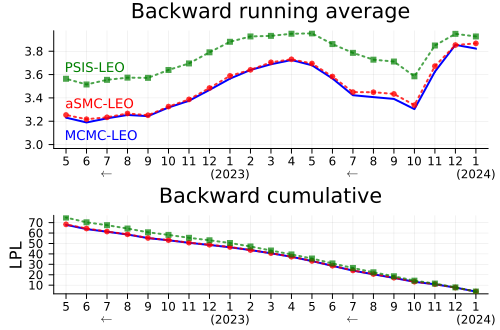

In [148]:
let
    # Store LPDs as matrix
    _data = [LPD_mcmc LPD_smc LPD_psis]

    """Plot 1: cumulative LPD"""
    plot(leave_ends, cumsum(_data; dims=1),
        label="",
        color=[:blue :red :green],
        linestyle=[:solid :dot :dot],
        mswidth=0, markershape=[:pixel :o :square], markersize=3,
        linewidth=2, alpha=[1 0.8 0.7],
        legend=:topright
    )
    plt_1 = plot!()

    """Plot 2: running average LPD"""
    plot(leave_ends, cumsum(_data; dims=1) ./ (1:size(_data,1)),
        color=[:blue :red :green],
        linestyle=[:solid :dot :dot],
        mswidth=0, markershape=[:pixel :o :square], markersize=3,
        linewidth=2, alpha=[1 0.8 0.7],
        legend=false
    )
    (_min, _max) = ylims(plot!())
    annotate!(leave_ends[end], mean(LPD_mcmc) - 0.15, text("MCMC-LEO", 9, :blue, :left))
    annotate!(leave_ends[end], mean(LPD_smc) + 0.10, text("aSMC-LEO", 9, :red, :left))
    annotate!(leave_ends[end], mean(LPD_psis) + 0.10, text("PSIS-LEO", 9, :green, :left))
    plt_2 = plot!(ylim=(_min - 0.2, _max))

    function _label_date(d::Date)::String
        if month(d) == 1
            "$(month(d))\n($(year(d)))"
        elseif month(d) == 7
            "$(month(d))\n" * L"\leftarrow"
        else
            "$(month(d))"
        end
    end
    
    plt_a = plot(plt_2, plt_1, layout=grid(2,1,heights=[0.6,0.4]), size=(500,330),
        title=["Backward running average" "Backward cumulative"],
        ylabel=[" " "LPL"],
        xticks=(leave_ends, df.index[leave_ends] .|> _label_date),
        tick_direction=:out,
        #framestyle=:box,
    ) |> display
    
    _dir = "img_$(SESSION)"
    isdir(_dir) || mkpath(_dir) # Ensure path is present
    savefig(joinpath(_dir, "yield-lpd-compare.pdf"))
end;

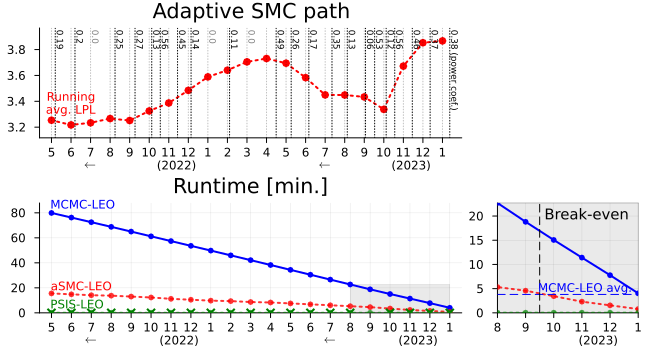

In [147]:
let
    function _label_date(d::Date)::String
        if month(d) == 12
            "$(month(d))\n($(year(d)))" * repeat(" ", 6)#year(d) == 2024 ? 6 : 0)
        elseif month(d) == 7
            "$(month(d))\n" * L"\leftarrow"
        else
            "$(month(d))"
        end
    end
    
    # Load SMC results
    (; particles, ϕ_history, L_history) = load_SMC()

    # Plot runnning-avg LPD in the background
    _data = cumsum(LPD_smc; dims=1)
    _data = _data ./ (1:size(_data,1))
    plot(leave_ends, _data,
        label="", color=:red, linestyle=:dot,
        mswidth=0, markershape=:o, linewidth=2, alpha=1,
    )

    # Plot vlines where SMC intervenes with the MCMC kernel
    (_min, _max) = extrema(_data)
    x_vec = Float64[]
    for (T_i, T) in enumerate(leave_ends)
        
        _x = T .+ (1 .- ϕ_history[Name(T), Name(L_history[:T => T])])
        vline!([_x], label="", style=:dot, color=:black, alpha=0.25)
        
        _x = T .+ (1 .- ϕ_history[Name(T), Name.(1:L_history[:T => T]-1)])
        vline!(_x, label="", style=:dot, color=:black)
        x_vec = [x_vec; _x]
        
        for _x_i in _x
            _text = round(_x_i - T; digits=2)
            if T_i == 1
                _text = "$(_text) (power coef.)"
            end
            annotate!(_x_i + 0.24, _max + 0.13, text("  $(_text)", :left, :black, 6, rotation=-90))
        end
    end
    T_annotate_candidate = [T for T in leave_ends if sum(@. T-1/2 ≤ x_vec ≤ T+1) == 0]
    if isempty(T_annotate_candidate)
        annotate!(leave_ends[end] + 0.24, _max + 0.13, text("  0.0", :left, :gray, 6, rotation=-90))
    else
        for T in T_annotate_candidate
            annotate!(T + 0.24, _max + 0.13, text("  0.0", :left, :gray, 6, rotation=-90))
        end
    end

    """Plot 1: paths"""
    annotate!(leave_ends[end-1], _data[end-1] + .05, text("Running\navg. LPL", :red, :bottom, 8))
    plt_1 = plot!(title="Adaptive SMC path",
        ylim=(_min - 0.1, _max + 0.1), bottommargin=2Plots.mm,
        xticks=(leave_ends, df.index[leave_ends] .|> _label_date),
        grid=:none
    )

    """Plot 2: run times"""
    # Load runtimes
    times_smc = NamedArray(load(joinpath("output", "DNS", "smc", "times.jld"))["data"],
        leave_ends, :T)
    times_mcmc = load(joinpath("output", "DNS", "mcmc", "times_naive-leo.jld"))["data"]

    _mcmc_leo_avg_time = mean(times_mcmc)/60
    until_idx = maximum(findall(cumsum(Vector(times_smc/60)) .<= _mcmc_leo_avg_time))
    
    _data = cumsum([times_mcmc times_smc times_psis]; dims=1) / 60
    
    xlims, ylims = extrema(leave_ends[1:until_idx+2]), (0, 1.0_data[until_idx+2,1])
    color = RGBA(RGB(0.6, 0.6, 0.6), 0.2)
    
    plot([xlims[1], xlims[end], xlims[end], xlims[1]],
        [ylims[1], ylims[1], ylims[end], ylims[end]],
        seriestype=:shape,
        fillcolor=color,
        linewidth=0)
    
    plot!(leave_ends, _data,
        label="",
        color=[:blue :red :green],
        linestyle=[:solid :dot :dot],
        mswidth=0,
        markershape=:o,
        markersize=3,
        linewidth=2, alpha=[1 0.8 0.7],# legend=:topright,
        title="Runtime [min.]",
    )
    
    scatter!(leave_ends[k̂s_psis .> 0.7], _data[k̂s_psis .> 0.7, 3],
        label="", color=:green, mswidth=3, markershape=:x)
    annotate!(leave_ends[end], sum(times_mcmc)/60 + 7, text("MCMC-LEO", 8, :blue, :left))
    annotate!(leave_ends[end], sum(times_smc)/60 + 6, text("aSMC-LEO", 8, :red, :left))
    annotate!(leave_ends[end], sum(times_psis)/60 + 7, text("PSIS-LEO", 8, :green, :left))
    
    plt_2 = plot!(bottommargin=2Plots.mm,
        xticks=(leave_ends, df.index[leave_ends] .|> _label_date),
        ylim=(0, 1.1maximum(_data)))
    
    plot(leave_ends, _data,
        label="",
        color=[:blue :red :green],
        linestyle=[:solid :dot :dot],
        mswidth=0,
        markershape=:o,
        markersize=3,
        linewidth=2, alpha=[1 0.8 0.7],# legend=:topright,
        title="",
    )
    hline!([_mcmc_leo_avg_time], color=:blue, linestyle=:dash)
    annotate!(leave_ends[1+1], _mcmc_leo_avg_time, text("MCMC-LEO avg." * repeat(" ", 13), 8, :blue, :bottom))
    break_even_idx = mean([leave_ends[until_idx], leave_ends[until_idx+1]])
    vline!([break_even_idx], color=:black, linestyle=:dash)
    annotate!(break_even_idx, 0.9_data[until_idx+2,1], text(" Break-even", :left, 10))
    plt_2_2 = plot!(bottommargin=2Plots.mm,
        xticks=(leave_ends[1:until_idx+2], df.index[leave_ends[1:until_idx+2]] .|> _label_date),
        xlim=xlims, ylim=ylims,
        frame=:semi, bg_inside=color,
    )

    plot(plt_1, plot(axis=false, grid=false),
        plt_2, plt_2_2,
        layout=grid(2,2,heights=[0.5,0.5],widths=[0.75,0.25]), size=(650,350),
        rightmargin=permutedims([-3, 1, -3, 1] .* Plots.mm),
        tick_direction=:out,
        legend=false,
    ) |> display
    
    _dir = "img_$(SESSION)"
    isdir(_dir) || mkpath(_dir) # Ensure path is present
    savefig(joinpath(_dir, "yield-paths.pdf"))
end;